In [4]:
import s3fs
import numpy as np
import pandas as pd

from mvpa2.datasets.mri import fmri_dataset
from mvpa2 import cfg
import mvpa2.datasets as md
from mvpa2.measures import rsa

import pylab as pl

In [5]:
## Load the data file names
fs = s3fs.S3FileSystem(anon=True)
ll = fs.ls('natural-scenes-dataset/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR')
sess_beta_list = [l for l in ll if l.split('/')[6].startswith("betas") and l.endswith("nii.gz")]

behav_data = pd.read_csv('subj01/behav/final_response.tsv', sep='\t')

In [6]:
### Load the data
# load the first session
sess = 1
sess_fname = sess_beta_list[0]
print(f"Loading session {sess} data ...")
# load the session data
fs.get(sess_fname, "tmp.nii.gz")
sess_data = fmri_dataset("tmp.nii.gz", mask = "TPJfunc.nii")

# extract the behavioral data for the session
tmp_behav = behav_data[behav_data['SESSION'] == sess] 

# only take the trials that have an interaction_type (i.e., not null)
indices = tmp_behav['interaction_type'].notnull().tolist()

# take the beta values for those trials
all_sess_ds = sess_data[indices, :]

# add the target (interaction_type) and chunk (session) information to the dataset
targets = tmp_behav[indices]['interaction_type'].tolist()
chunks = tmp_behav[indices]['SESSION']

all_sess_ds.sa['targets'] = targets
all_sess_ds.sa['chunks'] = chunks

# add an attribute that determines whether the session should be included in the training or test dataset
if (sess) >=36:
    all_sess_ds.sa['train_or_test'] = ['test'] * len(all_sess_ds)
else:
    all_sess_ds.sa['train_or_test'] = ['train'] * len(all_sess_ds)

# then concatenate the other sessions to the first session
for sess, sess_fname in enumerate(sess_beta_list[1:3]): 
    print(f"Loading session {sess+2} data ...")
    # load the session data
    fs.get(sess_fname, "tmp.nii.gz")
    sess_data = fmri_dataset("tmp.nii.gz", mask = "TPJfunc.nii")

    # extract the behavioral data for the session
    tmp_behav = behav_data[behav_data['SESSION'] == (sess+2)] 

    # only take the trials that have an interaction_type (i.e., not null)
    indices = tmp_behav['interaction_type'].notnull().tolist()

    # take the beta values for those trials
    tmp_ds = sess_data[indices, :]

    # add the target (interaction_type) and chunk (session) information to the dataset
    targets = tmp_behav[indices]['interaction_type'].tolist()
    chunks = tmp_behav[indices]['SESSION']
    tmp_ds.sa['targets'] = targets
    tmp_ds.sa['chunks'] = chunks
    
    # add an attribute that determines whether the session should be included in the training or test dataset
    if (sess+2) >=36:
        tmp_ds.sa['train_or_test'] = ['test'] * len(tmp_ds)
    else:
        tmp_ds.sa['train_or_test'] = ['train'] * len(tmp_ds)
    
    # concatenate the tmp_ds to the all_sess_ds
    all_sess_ds = md.vstack((all_sess_ds, tmp_ds))

2
natural-scenes-dataset/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.nii.gz
3
natural-scenes-dataset/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.nii.gz


In [7]:
print(f"Dataset shape is: {all_sess_ds.shape}")

Dataset shape is: (37, 1000)


In [8]:
## convert the integer values to percent change (according to https://cvnlab.slite.com/p/6CusMRYfk0/Functional-data-NSD)
normalized_all_sess_ds = all_sess_ds.copy()
normalized_all_sess_ds.samples = normalized_all_sess_ds.samples.astype('float')/300
normalized_all_sess_ds.samples

array([[-5.33333333e-02,  2.73333333e-01,  1.63333333e-01, ...,
        -1.10666667e+00, -1.82000000e+00,  1.97000000e+00],
       [-3.46666667e-01,  2.00000000e-01, -1.17333333e+00, ...,
        -1.58666667e+00,  1.56000000e+00, -1.22666667e+00],
       [ 2.33333333e-01,  2.18333333e+00, -1.84000000e+00, ...,
        -7.66666667e-02,  1.33333333e-02,  1.39000000e+00],
       ...,
       [ 6.73333333e-01, -3.00000000e-01, -1.73333333e-01, ...,
         7.05666667e+00, -6.90000000e-01, -1.23400000e+01],
       [-7.10000000e-01,  9.53333333e-01, -2.17333333e+00, ...,
         2.21000000e+00, -1.90000000e-01, -1.85600000e+01],
       [ 8.73333333e-01, -9.66666667e-02, -2.33333333e-02, ...,
        -2.77666667e+00,  5.70000000e-01,  5.04333333e+00]])

In [9]:
## Helper function to plot the dissimilarity matrices
def plot_mtx(mtx, labels, title):
    pl.figure()
    pl.imshow(mtx, interpolation='nearest')
    pl.xticks(range(len(mtx)), labels, rotation=-45)
    pl.yticks(range(len(mtx)), labels)
    pl.title(title)
    pl.clim((0, 2))
    pl.colorbar()

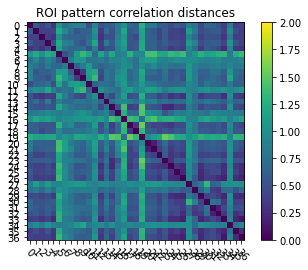

In [10]:
# basic ROI RSA -- dissimilarity matrix for the entire ROI
dsm = rsa.PDist(square=True)
res = dsm(normalized_all_sess_ds)
plot_mtx(res, np.arange(len(normalized_all_sess_ds)), 'ROI pattern correlation distances')